# Risk attribution with Student t distributed risk drivers



In [7]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

# import relevant packages
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# from codelib
from codelib.visualization.base import risk_waterfall_chart, waterfall_chart

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

Assume that we can specify the return of an asset using the following decomposition

$$
\mathbf{R} = \alpha + \beta_1 \mathbf{Z}_1 + \beta_2 \mathbf{Z}_2 + \varepsilon = \boldsymbol{\beta}^\top \mathbf{Z}
$$

where $\boldsymbol{\beta} = (\beta_1, \beta_2, 1)^\top = (0.5, 0.75, 1)^\top$ and 

$$
\mathbf{Z} = \begin{pmatrix} \mathbf{Z}_1 \\ \mathbf{Z}_2 \\ \alpha + \varepsilon  \end{pmatrix} \sim t(\boldsymbol{\mu}, \boldsymbol{\Sigma}, \nu)
$$

Assume that $\nu = 10$ and 

$$
\boldsymbol{\mu} = \begin{pmatrix} 0.04 \\ 0.08 \\ 0.0\end{pmatrix}
$$

and 

$$
\boldsymbol{\Sigma} = \begin{pmatrix} 0.1^2 & 0 & 0 \\ 0 & 0.15^2 & 0 \\ 0 & 0 & 0.05^2 \end{pmatrix}
$$

## Problem 1

The variance of $\mathbf{R}$ is given by 

$$
\text{Var}[\mathbf{R}] = \boldsymbol{\beta}^\top \text{Cov}[\mathbf{Z}]  \boldsymbol{\beta}
$$

What is the variance of $\mathbf{R}$? What is the standard deviation?

### Solution

We note that (from week 3)

$$
\text{Cov}[\mathbf{Z}] = \frac{\nu}{\nu - 2} \boldsymbol{\Sigma}
$$

Thus, we just plug into the formula

In [13]:
"""
Define relevant inputs
"""

p = 3
nu = 10
mu = np.array([0.04, 0.08, 0.0])
sigma_mat = np.diag([0.1**2, 0.15**2, 0.05**2])
cov_mat = nu /  (nu - 2) * sigma_mat
beta = np.array([0.5, 0.75, 1])

In [14]:
"""
Define function to calculate variance of asset
"""

def calculate_asset_variance(beta: np.ndarray, cov_mat: np.ndarray) -> float: 

    return beta @ cov_mat @ beta.T

In [15]:
var = calculate_asset_variance(beta, cov_mat)
var

np.float64(0.022070312499999998)

In [16]:
std = np.sqrt(var)
std

np.float64(0.1485608040500589)

## Problem 2

Following similar arguments as for a portfolio, the Euler decomposition of the standard devation of the asset return reads

$$
\sigma_R(\boldsymbol{\beta}) = \boldsymbol{\beta}^\top \frac{\text{Cov}[\mathbf{Z}]  \boldsymbol{\beta}}{\sqrt{\boldsymbol{\beta}^\top \text{Cov}[\mathbf{Z}] \boldsymbol{\beta}}} = \sum_{i=1}^3 \beta_i \frac{(\text{Cov}[\mathbf{Z}] \boldsymbol{\beta})_i }{\sqrt{\boldsymbol{\beta}^\top \text{Cov}[\mathbf{Z}] \boldsymbol{\beta}}}
$$

Attribute the risk using the above decomposition. Does the risk contributions sum to the total risk? Plot the results. 

### Solution

We can simply apply the formula from the lecture - just replace portfolio weights with $\boldsymbol{\beta}$!

In [17]:
def calculate_marginal_risks(beta: np.ndarray, cov_matrix: np.ndarray) -> np.ndarray:
    
    """
    Function that calculates marginal risk
    Parameters
    ----------
    beta: 
        Factor exposures. 
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    total_risk = np.sqrt(beta @ cov_matrix @ beta)
    inner_derivative = cov_matrix @ beta
    
    return inner_derivative / total_risk

def calculate_risk_contributions(beta: np.ndarray, cov_matrix: np.ndarray) -> np.ndarray:
    
    """
    Function that calculates risk contributions
    
    Parameters
    ----------
    beta: 
        Factor exposures.
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    mr = calculate_marginal_risks(beta, cov_matrix)
    
    return beta * mr

risk_contrib = calculate_risk_contributions(beta, cov_mat)
print("Risk contribution:")
print("Z_1: {:.2f}%'".format(risk_contrib[0] * 100))
print("Z_2: {:.2f}%'".format(risk_contrib[1] * 100))
print("Idiosyncratic: {:.2f}%'".format(risk_contrib[2] * 100))

Risk contribution:
Z_1: 2.10%'
Z_2: 10.65%'
Idiosyncratic: 2.10%'


In [18]:
risk_contrib.sum() # <- YES

np.float64(0.14856080405005892)

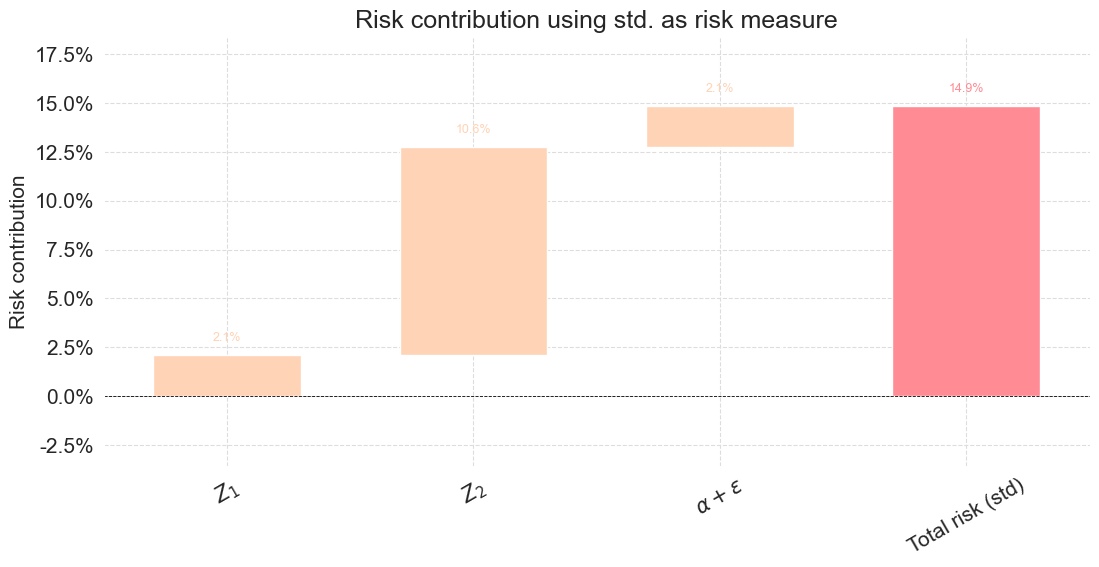

In [19]:
fig, ax = waterfall_chart(values=risk_contrib*100,
                          labels=["$Z_1$", "$Z_2$", "$\\alpha + \\epsilon$"],
                          formatting='{:,.1f}%',
                          total_label="Total risk (std)")

ax.set(ylabel="Risk contribution", title="Risk contribution using std. as risk measure")

fig.set_size_inches(12, 6);

## Problem 3

We have the general result that if $\mathbf{Z} \sim t(\boldsymbol{\mu}, \boldsymbol{\Sigma}, \nu)$ then

$$
\boldsymbol{a} + \boldsymbol{b} \mathbf{Z} \sim t(\boldsymbol{a}+\boldsymbol{b} \boldsymbol{\mu},\boldsymbol{b} \boldsymbol{\Sigma} \boldsymbol{b}^\top, \nu)
$$

Calculate the $\text{VaR}_{5\%} (\mathbf{R})$.


### Solution

In [20]:
mu_r = beta @ mu
var_r  = beta @ sigma_mat @ beta
std_r  = np.sqrt(var_r)

value_at_risk_5pct = -stats.t(df=nu, loc=mu_r, scale=std_r).ppf(0.05)
value_at_risk_5pct

np.float64(0.16083407519238585)

## Problem 4

We have the general result that if $\mathbf{R} \sim t(\mu, \sigma^2, \nu)$ then

$$
R = \mu + \sigma Y
$$

where $Y \sim t(0, 1, \nu)$. Using this result will enable us to define the Euler decomposition 

$$
\text{VaR}_{\alpha} (\mathbf{R}) = \boldsymbol{\beta}^\top (-\boldsymbol{\mu} - \frac{\boldsymbol{\Sigma}  \boldsymbol{\beta}}{\sqrt{\boldsymbol{\beta}^\top \boldsymbol{\Sigma} \boldsymbol{\beta}}} q_t(\alpha))
$$

where $q_t(\alpha)$ is the quantile of a $t(0, 1, \nu)$ distributed random variable. 

Attribute the risk using the above decomposition. Does the risk contributions sum to the total risk? Plot the results. 


### Solution

In [21]:
def calculate_risk_contributions_t_var(beta: np.ndarray, mu: np.ndarray, sigma_mat: np.ndarray, nu: int, alpha: float = 0.05) -> np.ndarray:
    
    """
    Function that calculates risk contribution using Value-at-Risk as risk measure.
    It is assumed that risk drivers follow a multivariate t distribution.

    Parameters
    ----------
    factor exposures:
        Factor exposures
    mu:
        Vector of expected returns
    sigma_mat:
        Covariance matrix
    alpha:
        Confidence level

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr = -mu - sigma_mat @ beta / np.sqrt(beta @ sigma_mat @ beta) * stats.t(df=nu).ppf(alpha)
    
    return beta * mr

In [22]:
risk_contrib_var = calculate_risk_contributions_t_var(beta, mu, sigma_mat, nu, 0.05)
risk_contrib_var

array([0.0141004 , 0.11263328, 0.0341004 ])

In [23]:
risk_contrib_var.sum() #<- YES

np.float64(0.16083407519238585)

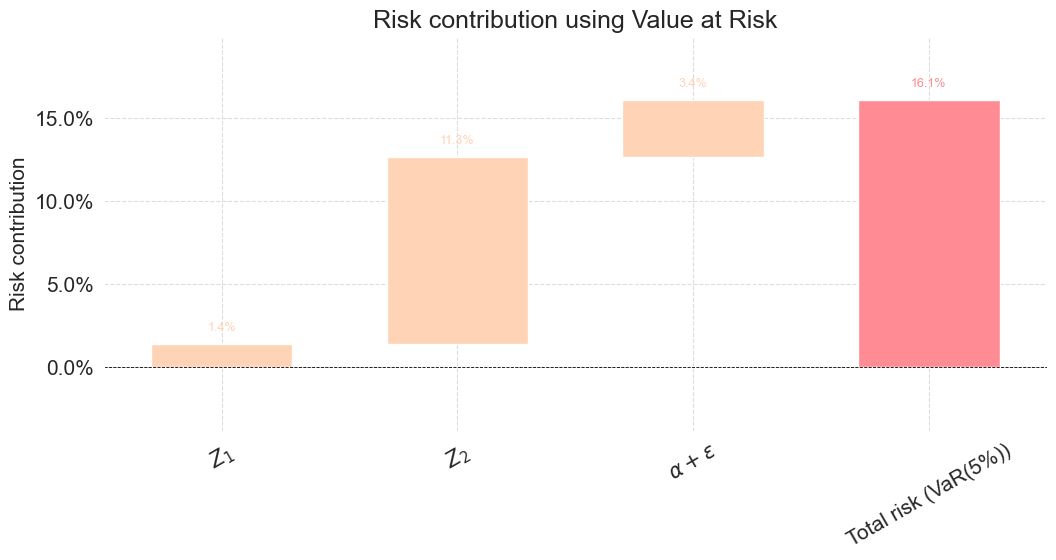

In [24]:
fig, ax = waterfall_chart(values=risk_contrib_var*100,
                          labels=["$Z_1$", "$Z_2$", "$\\alpha + \\epsilon$"],
                          formatting='{:,.1f}%',
                          total_label="Total risk (VaR(5%))")

ax.set(ylabel="Risk contribution", title="Risk contribution using Value at Risk")

fig.set_size_inches(12, 6);